In [2]:
%reload_ext autoreload
%autoreload 2


In [3]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

In [4]:
import hydra
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()
# setup hydra config global for loading this notebook
hydra.initialize(config_path="configs", version_base=None)
cfg = hydra.compose(config_name="expr_baseline")


In [5]:
from main import setup_environment, get_checkpoint_info, is_training_complete

# Setup environment
device = setup_environment(cfg)

# Get checkpoint info
output_dir, checkpoint = get_checkpoint_info(cfg, num_epochs=cfg.training.num_epochs)

# Instantiate everything
bridge = hydra.utils.instantiate(cfg.bridge)
dataset = hydra.utils.instantiate(cfg.dataset)
    

14:41:59 - INFO - Using device: cuda
14:42:00 - INFO - Using compile: False
14:42:26 - INFO - Found checkpoint: /orcd/data/omarabu/001/njwfish/counting_flows/outputs/61be507a6200/model.pt


Train split: 931, Test split: 49
Train cells: 1202750, Test cells: 61517


In [5]:
import numpy as np
import torch

ctx_window_size    = 196_608
target_window_size = 896
stride             = 896   # tiles exactly; use <= 896 to allow overlap

whalf = ctx_window_size // 2
thalf = target_window_size // 2

base_idx = np.concatenate(list(dataset.test_individual_idxs.values()))
device = "cuda"  # or "cpu"


gene_counts = {}
for ci, gs, ge, gn in zip(dataset._eligible_cidx, dataset._eligible_start, dataset._eligible_end, dataset._eligible_gene_name):

    chrom_beg  = dataset.chrom_starts[ci]
    gene_start = int(chrom_beg + int(gs))
    gene_end   = int(chrom_beg + int(ge))  # end-exclusive
    gene_len   = int(gene_end - gene_start)

    print(gene_len)

    big_seq = dataset.get_seq(gene_start - whalf, gene_end + whalf)
    assert len(big_seq) == gene_len + 2*whalf

    # Centers whose 896bp target is fully inside the gene
    first_center = thalf
    last_center  = gene_len - thalf
    # if last_center < first_center:
    #     continue  # gene shorter than target; skip or handle separately

    centers_local = np.arange(first_center, last_center + 1, stride, dtype=np.int64)
    if len(centers_local) == 0:
        centers_local = np.array([first_center])
    # ensure we always include a tail center that lands exactly on the end
    if centers_local[-1] != last_center and centers_local[-1] != first_center:
        centers_local = np.append(centers_local, last_center)

    gene_counts[gn] = dataset.fast_get_overlap_raw(base_idx, (gene_start, gene_end))

# save gene_counts with pickle
import pickle as pkl
pkl.dump(gene_counts, open("results/expr/gene_counts_true.pkl", "wb"))


523
7098
26277
5077
7105
36280
37494
2396
21619
4522
7814
28181
4671
6729
4514
2784
9089
7508
21570
5127


In [6]:
gene_counts_cb = pkl.load(open("results/expr/gene_counts.pkl", "rb"))
gene_counts_baseline = pkl.load(open("results/expr/gene_counts_baseline.pkl", "rb"))

In [10]:
baseline_mse = []
cb_mse = []
for gn in gene_counts_cb.keys():
    true_profile = gene_counts[gn]
    cb_profile = gene_counts_cb[gn]
    baseline_profile = gene_counts_baseline[gn]
    baseline_mse.append(((true_profile.mean(axis=0) - baseline_profile.mean(axis=0))**2).mean())
    cb_mse.append(((true_profile.mean(axis=0) - cb_profile.mean(axis=0))**2).mean())
print("baseline", np.mean(baseline_mse))
print("cb", np.mean(cb_mse))

baseline 2.5904326450125152
cb 0.6014023167356254


In [13]:
import numpy as np
import torch

ctx_window_size    = 196_608
target_window_size = 896
stride             = 896   # tiles exactly; use <= 896 to allow overlap

whalf = ctx_window_size // 2
thalf = target_window_size // 2

full_base_idx = np.concatenate(list(dataset.test_individual_idxs.values()))
base_cell_types = dataset.target_cond[full_base_idx]
device = "cuda"  # or "cpu"


gene_counts = {}
for cell_type in range(dataset.target_cond.shape[1]):
    gene_counts[cell_type] = {}
    base_idx = full_base_idx[base_cell_types[:, cell_type] == 1]
    for ci, gs, ge, gn in zip(dataset._eligible_cidx, dataset._eligible_start, dataset._eligible_end, dataset._eligible_gene_name):

        chrom_beg  = dataset.chrom_starts[ci]
        gene_start = int(chrom_beg + int(gs))
        gene_end   = int(chrom_beg + int(ge))  # end-exclusive
        gene_len   = int(gene_end - gene_start)

        print(gene_len)

        big_seq = dataset.get_seq(gene_start - whalf, gene_end + whalf)
        assert len(big_seq) == gene_len + 2*whalf

        # Centers whose 896bp target is fully inside the gene
        first_center = thalf
        last_center  = gene_len - thalf
        # if last_center < first_center:
        #     continue  # gene shorter than target; skip or handle separately

        centers_local = np.arange(first_center, last_center + 1, stride, dtype=np.int64)
        if len(centers_local) == 0:
            centers_local = np.array([first_center])
        # ensure we always include a tail center that lands exactly on the end
        if centers_local[-1] != last_center and centers_local[-1] != first_center:
            centers_local = np.append(centers_local, last_center)

        gene_counts[cell_type][gn] = dataset.fast_get_overlap_raw(base_idx, (gene_start, gene_end))

# save gene_counts with pickle
import pickle as pkl
pkl.dump(gene_counts, open("results/expr/cell_type_gene_counts_true.pkl", "wb"))

523
7098
26277
5077
7105
36280
37494
2396
21619
4522
7814
28181
4671
6729
4514
2784
9089
7508
21570
5127
523
7098
26277
5077
7105
36280
37494
2396
21619
4522
7814
28181
4671
6729
4514
2784
9089
7508
21570
5127
523
7098
26277
5077
7105
36280
37494
2396
21619
4522
7814
28181
4671
6729
4514
2784
9089
7508
21570
5127
523
7098
26277
5077
7105
36280
37494
2396
21619
4522
7814
28181
4671
6729
4514
2784
9089
7508
21570
5127
523
7098
26277
5077
7105
36280
37494
2396
21619
4522
7814
28181
4671
6729
4514
2784
9089
7508
21570
5127
523
7098
26277
5077
7105
36280
37494
2396
21619
4522
7814
28181
4671
6729
4514
2784
9089
7508
21570
5127
523
7098
26277
5077
7105
36280
37494
2396
21619
4522
7814
28181
4671
6729
4514
2784
9089
7508
21570
5127
523
7098
26277
5077
7105
36280
37494
2396
21619
4522
7814
28181
4671
6729
4514
2784
9089
7508
21570
5127
523
7098
26277
5077
7105
36280
37494
2396
21619
4522
7814
28181
4671
6729
4514
2784
9089
7508
21570
5127
523
7098
26277
5077
7105
36280
37494
2396
21619
4522
78

In [10]:
import pickle as pkl
gene_counts_cell_type_cb = pkl.load(open("results/expr/cell_type_gene_counts.pkl", "rb"))
gene_counts_cell_type_baseline = pkl.load(open("results/expr/cell_type_gene_counts_baseline.pkl", "rb"))
gene_counts_cell_type_true = pkl.load(open("results/expr/cell_type_gene_counts_true.pkl", "rb"))

In [ ]:
cb_cell_type_mse = {}
baseline_cell_type_mse = {}
for cell_type, ct_name in enumerate(dataset.sd.obs[dataset.cell_type_col].unique()):
    cb_cell_type_mse[cell_type] = []
    baseline_cell_type_mse[cell_type] = []
    for gn in gene_counts_cell_type_true[cell_type].keys():
        true_profile = gene_counts_cell_type_true[cell_type][gn]
        cb_profile = gene_counts_cell_type_cb[cell_type][gn]
        baseline_profile = gene_counts_cell_type_baseline[cell_type][gn]
        baseline_cell_type_mse[cell_type].append(((true_profile.mean(axis=0) - baseline_profile.mean(axis=0))**2).mean())
        cb_cell_type_mse[cell_type].append(((true_profile.mean(axis=0) - cb_profile.mean(axis=0))**2).mean())

cell_type 0
baseline 3.596295725099265
cb 1.4020663504960198
cell_type 1
baseline 0.4154721903528757
cb 0.3637876051161385
cell_type 2
baseline 3.382410765443646
cb 1.303655271864352
cell_type 3
baseline 2.6190296443050185
cb 1.0015405238317243
cell_type 4
baseline 1.065046646782866
cb 0.539825966627922
cell_type 5
baseline 2.5563134229923863
cb 1.0913986869165935
cell_type 6
baseline 3.3811816964253056
cb 1.311448294806039
cell_type 7
baseline 6.741537214469039
cb 3.4156597018484605
cell_type 8
baseline 1.623807174434793
cb 0.7806060101266394
cell_type 9
baseline 1.4847679659047075
cb 0.7515667286181374
cell_type 10
baseline 1.2531219380299858
cb 0.675886053951434
cell_type 11
baseline 9.301541756519116
cb 4.4747400841234235
cell_type 12
baseline 10763.906192738503
cb 10696.93436850713
cell_type 13
baseline 3.428013495296761
cb 1.3225657229763237


In [31]:
# print overall means 
print("baseline", np.mean([np.mean(baseline_cell_type_mse[cell_type]) for cell_type in baseline_cell_type_mse.keys() if cell_type != 12]))
print("cb", np.mean([np.mean(cb_cell_type_mse[cell_type]) for cell_type in cb_cell_type_mse.keys() if cell_type != 12]))


baseline 3.142195356619674
cb 1.4180574616387085


In [28]:

# configurable
DEC = 3  # number of decimals

ct_names = list(dataset.sd.obs[dataset.cell_type_col].unique())

# start building LaTeX
tex = []
tex.append(r"\begin{tabular}{lrr}")
tex.append(r"\toprule")
tex.append(r"Cell type & Baseline MSE & CB MSE \\")
tex.append(r"\midrule")

for i, ct_name in enumerate(ct_names):
    base_mean = float(np.mean(baseline_cell_type_mse[i]))
    cb_mean   = float(np.mean(cb_cell_type_mse[i]))

    base_str = f"{base_mean:.{DEC}f}"
    cb_str   = f"{cb_mean:.{DEC}f}"

    # bold the lower (better) mean
    if cb_mean < base_mean:
        cb_str = r"\textbf{" + cb_str + r"}"
    elif base_mean < cb_mean:
        base_str = r"\textbf{" + base_str + r"}"

    tex.append(f"{ct_name} & {base_str} & {cb_str} \\\\")

tex.append(r"\bottomrule")
tex.append(r"\end{tabular}")

print("\n".join(tex))

\begin{tabular}{lrr}
\toprule
Cell type & Baseline MSE & CB MSE \\
\midrule
CD4 ET & 3.596 & \textbf{1.402} \\
NK & 0.415 & \textbf{0.364} \\
CD4 NC & 3.382 & \textbf{1.304} \\
CD8 S100B & 2.619 & \textbf{1.002} \\
CD8 ET & 1.065 & \textbf{0.540} \\
B IN & 2.556 & \textbf{1.091} \\
CD8 NC & 3.381 & \textbf{1.311} \\
B Mem & 6.742 & \textbf{3.416} \\
NK R & 1.624 & \textbf{0.781} \\
Mono NC & 1.485 & \textbf{0.752} \\
Mono C & 1.253 & \textbf{0.676} \\
DC & 9.302 & \textbf{4.475} \\
Plasma & 10763.906 & \textbf{10696.934} \\
CD4 SOX4 & 3.428 & \textbf{1.323} \\
\bottomrule
\end{tabular}


In [48]:
gene_counts_deconv_cb = pkl.load(open("results/expr/deconv_gene_counts.pkl", "rb"))
gene_counts_deconv_true = pkl.load(open("results/expr/deconv_gene_counts_true.pkl", "rb"))

In [106]:
count_matrices = {} 
count_matrices_true = {}
for indiv_idx in gene_counts_deconv_cb.keys():
    if indiv_idx == '747_748':
        continue
    if len(gene_counts_deconv_cb[indiv_idx]) == 0:
        continue
    count_matrices[indiv_idx] = np.zeros((list(gene_counts_deconv_cb[indiv_idx].values())[0].shape[0], len(dataset._eligible_gene_name)))
    count_matrices_true[indiv_idx] = np.zeros((list(gene_counts_deconv_true[indiv_idx].values())[0].shape[0], len(dataset._eligible_gene_name)))
    for i, gn in enumerate(dataset._eligible_gene_name):
        count_matrices[indiv_idx][:, i] = np.quantile(gene_counts_deconv_cb[indiv_idx][gn], 0.995, axis=1, method='nearest')
        count_matrices_true[indiv_idx][:, i] = gene_counts_deconv_true[indiv_idx][gn].max(axis=1)


In [107]:
((count_matrices['677_678'].mean(axis=0) - count_matrices_true['677_678'].mean(axis=0))**2).mean()

np.float64(41.2464126023496)

In [108]:
count_matrices['677_678']

array([[ 3., 14.,  1., ..., 14.,  9., 11.],
       [ 6., 20.,  0., ..., 12.,  5., 21.],
       [ 7., 28.,  0., ..., 15., 12., 26.],
       ...,
       [ 7.,  5.,  0., ...,  8.,  7.,  7.],
       [ 3., 28.,  0., ..., 19., 12., 15.],
       [ 6., 12.,  0., ..., 10., 11., 11.]], shape=(1590, 20))

In [131]:
count_matrices_true['677_678']

array([[ 1., 14.,  0., ..., 12.,  9., 11.],
       [ 0., 23.,  0., ..., 32., 25., 23.],
       [ 1., 24.,  0., ..., 18., 20., 16.],
       ...,
       [ 0.,  9.,  0., ...,  9.,  5.,  7.],
       [ 0., 22.,  0., ..., 18., 19., 16.],
       [ 0., 10.,  0., ..., 11., 10.,  8.]], shape=(1590, 20))

In [120]:
map_indiv_str_to_idx = {k: i for i, k in enumerate(dataset.test_individual_idxs.keys())}

In [128]:
cond = np.load("/orcd/data/omarabu/001/njwfish/counting_flows/results/expr/test_target_cond.npy")
target_idxs_local = np.load('/orcd/data/omarabu/001/njwfish/counting_flows/results/expr/test_mat_idxs.npy', allow_pickle=True).item()
target_counts = np.load('/orcd/data/omarabu/001/njwfish/counting_flows/results/expr/test_full_matrix_max.npy')

In [139]:
cell_type_means = (cond.T @ target_counts) / cond.sum(axis=0, keepdims=True).T

array([4, 2, 2, ..., 4, 2, 4], shape=(1590,))

In [160]:
ct_proportions = []
true_ct_proportions = []

for indiv_idx in count_matrices:
    # get the nearest cell type mean for each cell in each individual
    cell_type_assigments = np.linalg.norm(cell_type_means[None, :, :] - count_matrices[indiv_idx][:, None, :], axis=2).argmin(axis=1)
    # compute cell type proportions
    cell_type_proportions = np.bincount(cell_type_assigments, minlength=14) / len(cell_type_assigments)

    # compute true cell type proportions
    true_cell_type_assigments = cond[target_idxs_local[map_indiv_str_to_idx[indiv_idx]]].argmax(axis=1)
    true_cell_type_proportions = np.bincount(true_cell_type_assigments, minlength=14) / len(true_cell_type_assigments)

    ct_proportions.append(cell_type_proportions)
    true_ct_proportions.append(true_cell_type_proportions)

ct_proportions = np.array(ct_proportions)
true_ct_proportions = np.array(true_ct_proportions)


In [ ]:
ct_proportions = []
true_ct_proportions = []

for indiv_idx in count_matrices:
    # get the nearest cell type mean for each cell in each individual
    cell_type_assigments = np.linalg.norm(cell_type_means[None, :, :] - count_matrices[indiv_idx][:, None, :], axis=2).argmin(axis=1)
    # compute cell type proportions
    cell_type_proportions = np.bincount(cell_type_assigments, minlength=14) / len(cell_type_assigments)

    # compute true cell type proportions
    true_cell_type_assigments = cond[target_idxs_local[map_indiv_str_to_idx[indiv_idx]]].argmax(axis=1)
    true_cell_type_proportions = np.bincount(true_cell_type_assigments, minlength=14) / len(true_cell_type_assigments)

    ct_proportions.append(cell_type_proportions)
    true_ct_proportions.append(true_cell_type_proportions)

ct_proportions = np.array(ct_proportions)
true_ct_proportions = np.array(true_ct_proportions)

/home/njwfish/miniconda3/envs/seq/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


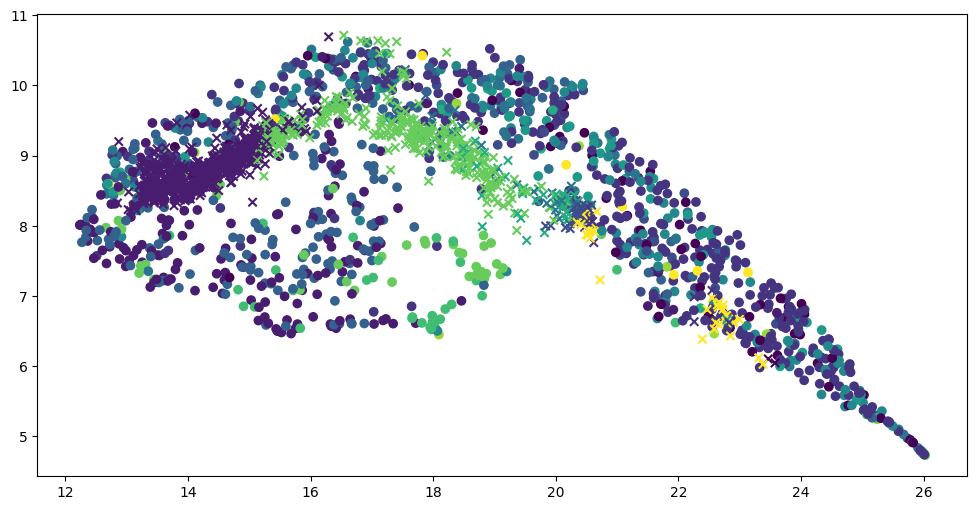

In [180]:
# plot the true cells in umap space colored by cell type and the predicted cells in umap space colored by cell type using different markers
import matplotlib.pyplot as plt

# compute umap of count_matrices[indiv_idx] and count_matrices_true[indiv_idx]
import umap

umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=10, min_dist=0.1)
umap_model.fit(count_matrices_true[indiv_idx])
true_umap = umap_model.transform(count_matrices_true[indiv_idx])
pred_umap = umap_model.transform(count_matrices[indiv_idx])


# plot the true cells in umap space colored by cell type and the predicted cells in umap space colored by cell type using different markers
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(12, 6))

plt.scatter(true_umap[:, 0], true_umap[:, 1], c=true_cell_type_assigments, cmap='viridis', marker='o')
plt.scatter(pred_umap[:, 0], pred_umap[:, 1], c=cell_type_assigments, cmap='viridis', marker='x')
plt.show()




In [164]:
import numpy as np
from scipy.spatial.distance import jensenshannon

def jsd_ct(predicted: np.ndarray, true: np.ndarray, eps: float = 1e-12):
    """
    Paper Eq. (2): JSD per cell type k between Q(P_k) and Q(T_k),
    where each column is normalized across spots.

    Parameters
    ----------
    predicted, true : arrays of shape (n_spots, n_celltypes)

    Returns
    -------
    jsd_per_ct : (n_celltypes,) JSD for each cell type (in nats)
    jsd_mean   : scalar mean across cell types
    """
    if predicted.shape != true.shape:
        raise ValueError("Arrays must have the same shape.")

    # stabilize and normalize each column to sum to 1 (distribution over spots)
    P = predicted + eps
    P /= P.sum(axis=0, keepdims=True)
    Q = true + eps
    Q /= Q.sum(axis=0, keepdims=True)

    M = 0.5 * (P + Q)

    # KL terms summed over spots (axis=0), yielding one value per cell type
    jsd_per_ct = 0.5 * np.sum(P * (np.log(P) - np.log(M)), axis=0) + \
                 0.5 * np.sum(Q * (np.log(Q) - np.log(M)), axis=0)

    return jsd_per_ct, float(jsd_per_ct.mean())

def mean_jsd(predicted: np.ndarray, true: np.ndarray):
    """
    Compute Jensen–Shannon divergence row-wise between two arrays 
    of same shape and return all values and their mean.

    Parameters
    ----------
    predicted : np.ndarray
        2D array (n_rows x n_features).
    true : np.ndarray
        2D array of same shape as predicted.

    Returns
    -------
    jsd_values : np.ndarray
        Array of shape (n_rows,) with JSD values for each row.
    jsd_mean : float
        Mean JSD across all rows.
    """
    if predicted.shape != true.shape:
        raise ValueError("Arrays must have the same shape.")

    jsd_values = []
    for i in range(predicted.shape[0]):
        # normalize rows to sum to 1 (to be valid probability distributions)
        p = predicted[i] / np.sum(predicted[i])
        q = true[i] / np.sum(true[i])
        jsd = jensenshannon(p, q, base=2) ** 2  # square because scipy returns sqrt(JSD)
        jsd_values.append(jsd)

    jsd_values = np.array(jsd_values)
    return jsd_values, jsd_values.mean()


import numpy as np

def rmse(predicted: np.ndarray, true: np.ndarray):
    """
    Compute squared error per column, normalize by column sum,
    then average across columns.

    Parameters
    ----------
    predicted : np.ndarray
        2D array (n_rows x n_cols).
    true : np.ndarray
        2D array of same shape.

    Returns
    -------
    float
        Average normalized squared error across columns.
    """
    if predicted.shape != true.shape:
        raise ValueError("Arrays must have the same shape.")
    sq_err = (predicted - true) ** 2
    col_sums = true.sum(axis=0)
    col_scores = sq_err.sum(axis=0) / col_sums
    return np.sqrt(col_scores.mean())

In [168]:
jsd_ct(ct_proportions, true_ct_proportions)

(array([0.25634104, 0.06070139, 0.14558359, 0.13426229, 0.1749817 ,
        0.09898182, 0.19699962, 0.22682539, 0.13216299, 0.10932622,
        0.14988685, 0.33263736, 0.13881681, 0.17101975]),
 0.16632334364810397)

In [163]:
# write out csvs for ct_proportions and true_ct_proportions
import pandas as pd

# Create DataFrames
pd.DataFrame(ct_proportions).to_csv("results/expr/ct_proportions.csv")
pd.DataFrame(true_ct_proportions).to_csv("results/expr/true_ct_proportions.csv")

array([0.05345912, 0.18301887, 0.2836478 , 0.00943396, 0.34465409,
       0.01383648, 0.05786164, 0.00503145, 0.02201258, 0.01383648,
       0.00754717, 0.00251572, 0.00251572, 0.00062893])

In [140]:
# compute the nearest cell type mean for each cell in each individual
for indiv_idx in count_matrices:
    dists = np.linalg.norm(cell_type_means - count_matrices[indiv_idx].mean(axis=0), axis=1)